# Data Preprocessing

In [12]:
%load_ext autoreload
%autoreload 2

In [10]:
from lateguru_ml.ml_logic.model import package_test

In [11]:
package_test()

Lateguru package works


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve


import xgboost as xgb
from xgboost import plot_importance

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

## Load preprocessed data

In [ ]:
# Load preprocessed data set from /data folder
file_path = '/content/drive/My Drive/Colab Notebooks/lateguru/data/preprocessed_treated_outliers.csv'

preprocessed_df = pd.read_csv(file_path)

print(preprocessed_df.head())

                  Time Origin Dest                 Carrier  Cancelled  \
0  2021-01-01 09:00:00    LAX  JFK  American Airlines Inc.      False   
1  2021-01-02 09:00:00    LAX  JFK  American Airlines Inc.      False   
2  2021-01-03 09:00:00    LAX  JFK  American Airlines Inc.      False   
3  2021-01-03 09:00:00    LAX  JFK  American Airlines Inc.      False   
4  2021-01-04 09:00:00    LAX  JFK  American Airlines Inc.      False   

  CancellationReason  Delayed  DepDelayMinutes  CarrierDelay  \
0      Not Cancelled    False              0.0           0.0   
1      Not Cancelled     True              2.0           0.0   
2      Not Cancelled     True             25.0          28.0   
3      Not Cancelled     True             25.0          28.0   
4      Not Cancelled    False              0.0           0.0   

   Weather_Delay_Length  ...  Sea_Level_Pressure  Visibility  Wind_Speed  \
0                   0.0  ...              1020.1    16093.40         0.0   
1                   0.0 

In [ ]:
preprocessed_df.columns

Index(['Time', 'Origin', 'Dest', 'Carrier', 'Cancelled', 'CancellationReason',
       'Delayed', 'DepDelayMinutes', 'CarrierDelay', 'Weather_Delay_Length',
       'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Temperature',
       'Feels_Like_Temperature', 'Altimeter_Pressure', 'Sea_Level_Pressure',
       'Visibility', 'Wind_Speed', 'Wind_Gust', 'Precipitation',
       'Ice_Accretion_3hr', 'Hour', 'Day_Of_Week', 'Month', 'Weather_Delayed'],
      dtype='object')

### Modelling for y_pred = 'Weather_Delayed'

In [ ]:
# Define y_pred and drop X columns based on 'delayed' feature engineering
X = preprocessed_df.drop(columns=['Weather_Delay_Length', 'Weather_Delayed'])
y = preprocessed_df['Weather_Delayed']

### Split into train/test (applicable to all model variations)

In [ ]:
#Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### Sampling down for testing

In [ ]:
# Sample only 10% of the data for quick testing
X_sample, _, y_sample, _ = train_test_split(
    X, y,
    test_size=0.9,  # Keep only 10% for the sample
    random_state=42,
    stratify=y  # Maintain the class distribution
)

### Split sampled data into train/test

In [ ]:
# Split the sampled data into train and test sets
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_sample, y_sample,
    test_size=0.2,  # 80% train, 20% test
    random_state=42, #Reproducibility
    stratify=y_sample  # Maintain the class distribution in the split
)

#### Enconding and scaling for y_pred = Weather_Delayed

In [ ]:
# Identify categorical, binary, and numeric features
categorical_features = ['CancellationReason', 'Origin', 'Dest', 'Carrier']
binary_features = ['Cancelled', 'Delayed']
numeric_features = ['DepDelayMinutes', 'CarrierDelay', 'NASDelay',
                    'SecurityDelay', 'LateAircraftDelay', 'Temperature', 'Feels_Like_Temperature',
                    'Altimeter_Pressure', 'Sea_Level_Pressure', 'Visibility', 'Wind_Speed',
                    'Wind_Gust', 'Precipitation', 'Ice_Accretion_3hr', 'Hour', 'Day_Of_Week', 'Month']

# One-hot encode categorical features
encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train_sample[categorical_features])
X_test_encoded = encoder.transform(X_test_sample[categorical_features])

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sample[numeric_features])
X_test_scaled = scaler.transform(X_test_sample[numeric_features])

# Combine the encoded categorical, scaled numeric, and binary features into a single array
X_train_preprocessed = np.hstack([X_train_encoded.toarray(), X_train_scaled, X_train_sample[binary_features]])
X_test_preprocessed = np.hstack([X_test_encoded.toarray(), X_test_scaled, X_test_sample[binary_features]])

### PCA Analysis

In [ ]:
#Assing PCA and number of components
pca = PCA(n_components=10)

#Apply PCA to scaled numeric features
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
#Concatenate arrays to form one array
X_train_preprocessed = np.hstack([X_train_encoded.toarray(), X_train_pca, X_train_sample[binary_features]])
X_test_preprocessed = np.hstack([X_test_encoded.toarray(), X_test_pca, X_test_sample[binary_features]])

In [ ]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_preprocessed, y_train_sample)

In [ ]:
# #Define Param Grid
# param_grid = {
#     'reg_alpha': [0, 0.1],  # L1
#     'reg_lambda': [0, 0.1],  # L2
#     'max_depth': [3, 5],  # Tree depth
#     'n_estimators': [50, 100]  # Boosting rounds
# }

### Initialise Model for Weather y_pred

In [ ]:
# Initialize the XGBoost model
xgb_model_weather = xgb.XGBClassifier(
    use_label_encoder=False,  # Disable the use of the label encoder - Need to test if this is required or not
    eval_metric='logloss',  # logloss as the evaluation metric
    random_state=42, # For reproducibility
    max_depth=5,  # Maximum depth of the trees
    n_estimators=100  # Number of boosting rounds
)

### Grid Search

In [ ]:
# #Grid Search
# grid_search = GridSearchCV(estimator=xgb_model_weather, param_grid=param_grid, scoring='recall', cv=3, n_jobs=2)

In [ ]:
# #Fit Grid Search on balanced training data
# grid_search.fit(X_train_balanced, y_train_balanced)

In [ ]:
# #Print the best parameters and score
# print(f"Best Parameters from Grid Search: {grid_search.best_params_}")
# print(f"Best F1 Score from Grid Search: {grid_search.best_score_}")

## Model Fit

In [ ]:
# Fit the model on the balanced training data
xgb_model_weather.fit(X_train_balanced, y_train_balanced)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:59:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### Learning Curves

In [ ]:
# Define the training sizes
train_sizes = np.array([0.5, 1.0])

# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgb_model_weather,
    X=X_train_balanced,  # Use the balanced training data
    y=y_train_balanced,
    train_sizes=train_sizes,
    cv=3,  # 5-fold cross-validation
    scoring='f1',  # Use F1 score to measure performance
)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:00:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:00:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:01:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/c

In [ ]:
# Calculate mean and standard deviation for training scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

In [ ]:
# Calculate mean and standard deviation for test scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

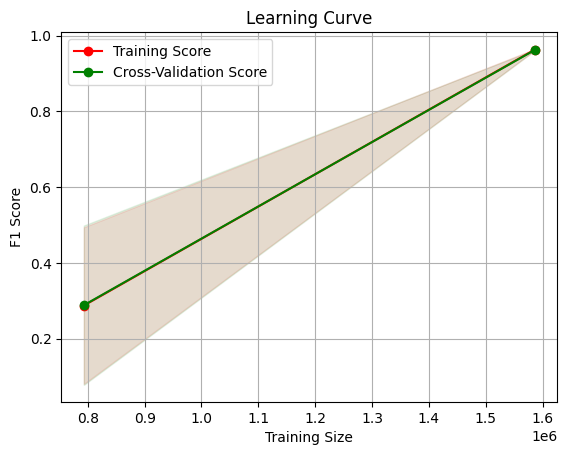

In [ ]:
# Plot learning curve
plt.figure()
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-Validation Score')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
# Evaluate the model on the test data
y_pred = xgb_model_weather.predict(X_test_preprocessed)

In [ ]:
# Calculate F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test_sample, y_pred)
print(f"F1 Score on the test set: {f1}")

F1 Score on the test set: 0.3146608160232139


In [ ]:
#Calculate Recall
from sklearn.metrics import recall_score
recall = recall_score(y_test_sample, y_pred)
print(f"Recall: {recall}")

Recall: 0.8082166878749318


In [ ]:
# Calculate ROC AUC
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test_sample, y_pred)
print(f"AUC-ROC: {auc_roc}")

AUC-ROC: 0.8733204896047716


In [ ]:
# Inspect Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_sample, y_pred)
print(f"Confusion Matrix:\n{cm}")

Confusion Matrix:
[[279078  18312]
 [  1055   4446]]


In [ ]:
# Generate Classifiation Report
from sklearn.metrics import classification_report
report = classification_report(y_test_sample, y_pred)
print(f"Classification Report:\n{report}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    297390
           1       0.20      0.81      0.31      5501

    accuracy                           0.94    302891
   macro avg       0.60      0.87      0.64    302891
weighted avg       0.98      0.94      0.95    302891



#### Plot Feature Importance

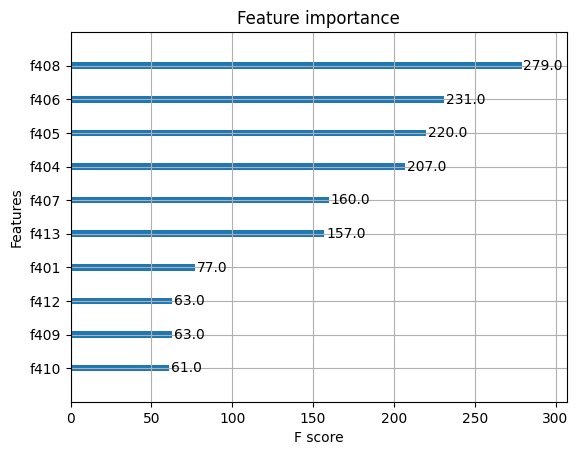

In [ ]:
# Plot the feature importance
plot_importance(xgb_model_weather, max_num_features=10)
plt.show()

In [ ]:
# Get the feature names from the encoder
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

In [ ]:
# Combine feature names
all_feature_names = np.hstack([
    encoded_feature_names,  # Encoded categorical feature names
    numeric_features,        # Numeric feature names
    # binary_features          # Binary feature names
])

In [ ]:
# Mapping indices to feature names
important_features = [(all_feature_names[i], importance) for i, importance in enumerate(xgb_model_weather.feature_importances_)]

# Sort by importance
important_features.sort(key=lambda x: x[1], reverse=True)

# Display top important features
for feature, importance in important_features[:30]:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Wind_Gust, Importance: 0.3850063979625702
Feature: Dest_LAS, Importance: 0.014936785213649273
Feature: Dest_MCO, Importance: 0.014524001628160477
Feature: Dest_LAX, Importance: 0.014064935967326164
Feature: Dest_BOS, Importance: 0.013563510961830616
Feature: Dest_ORD, Importance: 0.013461368158459663
Feature: Dest_ATL, Importance: 0.012071911245584488
Feature: Dest_PHX, Importance: 0.01102286297827959
Feature: Dest_SFO, Importance: 0.010370257310569286
Feature: Dest_IAH, Importance: 0.009733270853757858
Feature: Dest_EWR, Importance: 0.00957166776061058
Feature: Carrier_Envoy Air, Importance: 0.00905641820281744
Feature: Dest_LGA, Importance: 0.008756616152822971
Feature: Dest_AUS, Importance: 0.00871853157877922
Feature: Dest_DEN, Importance: 0.008573992177844048
Feature: Dest_BNA, Importance: 0.008346855640411377
Feature: Dest_RDU, Importance: 0.008334653452038765
Feature: Dest_JFK, Importance: 0.008236050605773926
Feature: Dest_MIA, Importance: 0.007942574098706245
Feature:

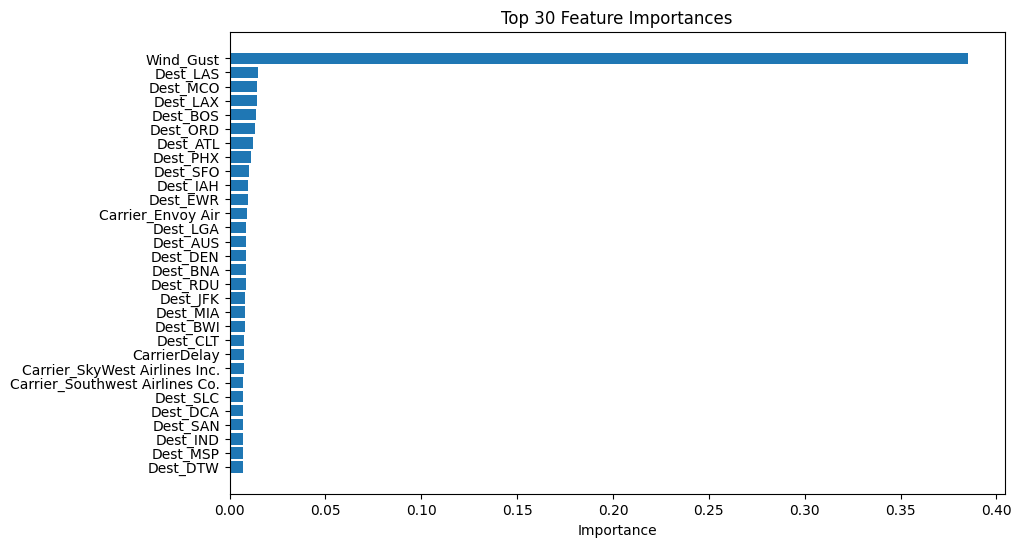

In [ ]:
# Sort the important features by importance
important_features.sort(key=lambda x: x[1], reverse=True)

# Extract the top 10 features and their importance
top_features = important_features[:30]
features = [f[0] for f in top_features]
importances = [f[1] for f in top_features]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# XGBoost

## Preprocessing Pipelines

In [ ]:
# # Define categorical, binary, and numeric features
# categorical_features = ['CancellationReason', 'Origin', 'Dest', 'Carrier']
# binary_features = ['Cancelled', 'Delayed']
# numeric_features = ['DepDelayMinutes', 'CarrierDelay', 'NASDelay',
#                     'SecurityDelay', 'LateAircraftDelay', 'Temperature', 'Feels_Like_Temperature',
#                     'Altimeter_Pressure', 'Sea_Level_Pressure', 'Visibility', 'Wind_Speed',
#                     'Wind_Gust', 'Precipitation', 'Ice_Accretion_3hr', 'Hour', 'Day_Of_Week', 'Month']

# # Define the preprocessing steps
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('onehot', OneHotEncoder(), categorical_features),  # Encode categorical features
#         ('passthrough_binary', 'passthrough', binary_features),  # Pass binary features as is
#         ('passthrough_numeric', 'passthrough', numeric_features)  # Pass numeric features as is
#     ],
#     remainder='drop'  # Drop the Time column and any other unspecified features
# )

## Scaling, Balacing & Modeling with Pipelines

### StandardScaler + SMOTE Pipeline

In [ ]:
# # Pipeline with StandardScaler and SMOTE, with XGBClassifier model
# pipeline_ss_smote = ImbPipeline([
#     ('preprocessor', preprocessor), #Preprocessor
#     ('scaler', StandardScaler(with_mean=False)),  # Standard Scaler for normalising features
#     ('sampling', SMOTE(random_state=42)),  # SMOTE for oversampling the minority class
# ])

In [ ]:
# # Grid Search parameters for Standard Scaler + SMOTE + XGBoost
# param_grid_ss_smote = {
#     'classifier__n_estimators': [100],  # Number of boosting rounds
#     'classifier__max_depth': [5]  # Maximum depth of the trees
# }

In [ ]:
# # Cross-validation strategy
# cv = StratifiedKFold(n_splits=5)

In [ ]:
# #Small X_train sample for local testing
# X_train_sample, _, y_train_sample, _ = train_test_split(
#     X_train, y_train,
#     test_size=0.9,  # Keep only 10% for the sample
#     random_state=42
# )

In [ ]:
# X_train_sample

In [ ]:
# # Running GridSearch
# grid_search_ss_smote_sample = GridSearchCV(pipeline_ss_smote, param_grid_ss_smote, cv=cv, scoring='f1', n_jobs=-1)

In [ ]:
# #Fit X_train_sample and y_train_sample
# grid_search_ss_smote_sample.fit(X_train_sample, y_train_sample)

In [ ]:
# # Store results
# best_model_ss_smote = grid_search_ss_smote_sample.best_estimator_
# print(f"Best Parameters for SS + SMOTE: {grid_search_ss_smote_sample.best_params_}")
# print(f"Best F1 Score from Sample Grid Search: {grid_search_ss_smote_sample.best_score_}")